# **Mental Health in the Tech Workplace**

In [592]:
# Import libaries
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

### Narrow datatset down to desired population:


In [593]:
survey = pd.read_csv('survey.csv') #(1433, 63)
united_states = (survey[survey["What country do you live in?"]
 == "United States of America"]) #(840, 63)
us_in_companies = united_states[united_states['Are you self-employed?']==0] #(709, 63)
df = (us_in_companies[(us_in_companies['What is your age?'] >= 16) 
& (us_in_companies['What is your age?'] <= 80)]) #(707, 63)

### Identify and rename desired columns:

In [594]:
employer_questions_survey = ['Does your employer provide mental health benefits as part of healthcare coverage?',
'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:']

employer_questions = ['MH Benefits', 'Formally Discussed', 'Resources Offered', 
'Anonymity Protected', 'Mental Health Leave']

rename_col_dict = {employer_questions_survey[i]: employer_questions[i] for i in range(len(employer_questions))}
df.rename(columns = rename_col_dict, inplace=True)

/usr/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [595]:
employee_perception_survey = ['Do you think that discussing a mental health disorder with your employer would have negative consequences?',
'Would you feel comfortable discussing a mental health disorder with your coworkers?',
'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
'Do you feel that your employer takes mental health as seriously as physical health?',
'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?']

employee_perception = ['Discussing MHD W/ Employer', 
'Discussing MHD W/ Coworkers', 'Discussing MHD W/ Supervisor', 
'Employers Take MH As Seriously as Physical Health', 
'Observed Negative Consequence For Discussing MH']

rename_col_dict = {employee_perception_survey[i]: employee_perception[i] for i in range(len(employee_perception))}
df.rename(columns = rename_col_dict, inplace=True)

In [596]:
demographics_survey = ['What is your age?',
'What is your gender?',
'How many employees does your company or organization have?']

demographics = ['Age', 'Gender', 'Company Size']

rename_col_dict = {demographics_survey[i]: demographics[i] for i in range(len(demographics))}
df.rename(columns = rename_col_dict, inplace=True)

In [597]:
desired_columns = demographics + employer_questions + employee_perception
df = df[desired_columns]

### Visualizing Our Data:


<AxesSubplot:title={'center':'How many employees does your company or organization have?'}>

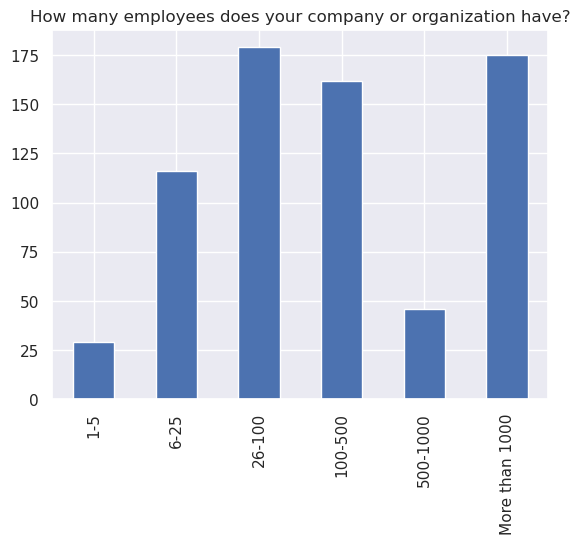

In [598]:
employee_count = df['Company Size'].value_counts()[['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000']]
employee_count.plot.bar(title="How many employees does your company or organization have?")

### Addressing Gender Column Inconsistencies:

In [599]:
df["Gender"]

1         male
4       Female
6            M
7       female
8       Female
         ...  
1416      Male
1419      male
1427    female
1430      Male
1431    Female
Name: Gender, Length: 707, dtype: object

In [600]:
conditions = [
    (df['Gender'].str.slice(stop=1).str.lower() =='f') | (df['Gender'].str.lower().str.contains("woman", na=False)),
    df['Gender'].str.slice(stop=1).str.lower() =='m'
    ]
df.loc[:,['Gender']] = np.select(conditions, ["F", "M"])
df = df[df['Gender'] != '0']
df['Gender']


1       M
4       F
6       M
7       F
8       F
       ..
1416    M
1419    M
1427    F
1430    M
1431    F
Name: Gender, Length: 687, dtype: object

<AxesSubplot:xlabel='Gender', ylabel='Count'>

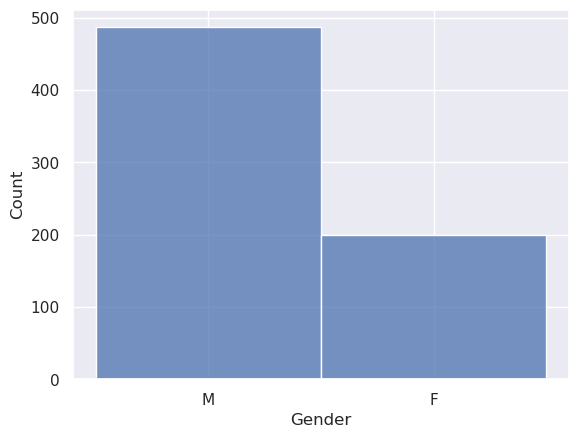

In [601]:
sns.set_theme(style="darkgrid")
sns.histplot(df['Gender'])

### Encoding categorical data as numerical data:

In [602]:
def encode_categorical_questions(columns: list, helper_func):
    for i in range(len(columns)):
        column = columns[i]
        dummies = pd.get_dummies(df[column])
        df.loc[:, column] = dummies[response_to_get_a_1[i]]
        helper_func(column, dummies, i)

# Encoding employer questions
response_to_get_a_1 = ['Yes', 'Yes', 'Yes', 'Yes', 'Very easy']
medical_leave_responses = [[.75, 'Somewhat easy'],[.5, 'Neither easy nor difficult'],[.25, 'Somewhat difficult'],[.25, 'I don\'t know']]

def encode_alternate_employer_questions_responses(column, dummies, i):
    df.loc[:, column] += .25*dummies['I don\'t know']
    if column == 'Mental Health Leave':
        for difficulty_level in medical_leave_responses:
            df.loc[:, column] += difficulty_level[0]*dummies[difficulty_level[1]]
            
encode_categorical_questions(employer_questions, encode_alternate_employer_questions_responses)

# Encoding employee perception questions
response_to_get_a_1 = ['No', 'Yes', 'Yes', 'Yes', 'No']
response_to_get_half = ['Maybe', 'Maybe', 'Maybe', 'I don\'t know']

def encode_alternate_employee_perception_responses(column, dummies, i):
    if i < len(response_to_get_half):
        df.loc[:, column] += .5*dummies[response_to_get_half[i]]

encode_categorical_questions(employee_perception, encode_alternate_employee_perception_responses)

In [603]:
# Encode Company Size
encoder = OrdinalEncoder(categories=[['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000']])
df.loc[:, ['Company Size (Encoded)']] = encoder.fit_transform(df[['Company Size']])

### Add Features:

In [604]:
# Create numerical scores from the average of each category:
df['Employee Perception Score'] = df.loc[:, employee_perception].mean(axis=1)
df['Employer Questions Score'] = df.loc[:, employer_questions].mean(axis=1)
df['Total Score'] = df[['Employer Questions Score', 'Employee Perception Score']].mean(axis=1)

In [605]:
# Create column for company size of greater than/less than 100
conditions = [df['Company Size (Encoded)'] < 3, df['Company Size (Encoded)'] >= 3]
values = ["Less than 100", "Greater than 100"]
df.loc[:,['Employee Count (Compared to 100)']] = np.select(conditions, values)

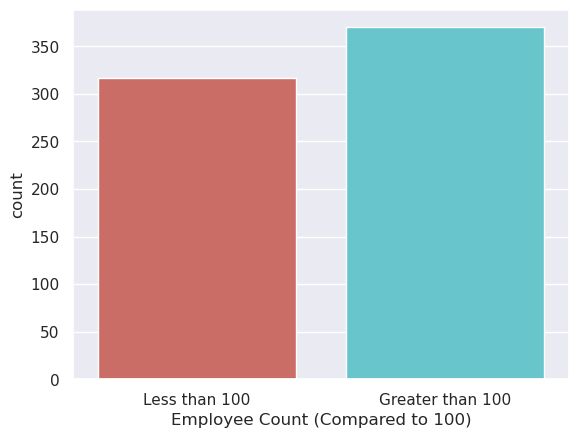

In [606]:
ax = sns.countplot(x="Employee Count (Compared to 100)", data=df, palette="hls")

### More Data Visualizations:

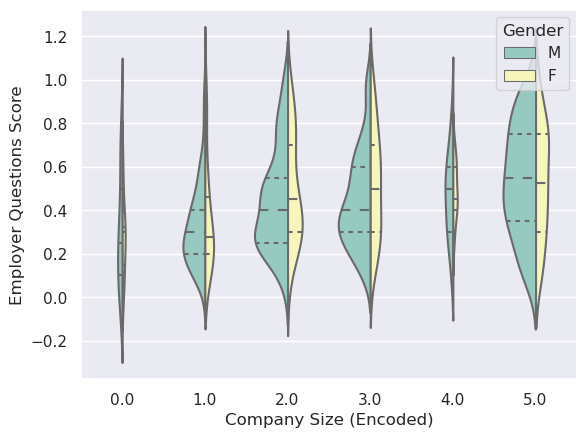

In [607]:
ax1 = sns.violinplot(x="Company Size (Encoded)", y="Employer Questions Score", hue="Gender",
                    data=df, palette="Set3", split=True,
                    scale="count", inner="quartile", scale_hue=False)

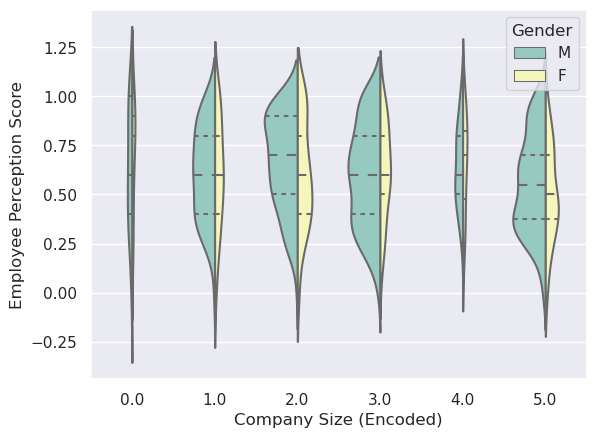

In [608]:
ax2 = sns.violinplot(x="Company Size (Encoded)", y="Employee Perception Score", hue="Gender",
                    data=df, palette="Set3", split=True,
                    scale="count", inner="quartile", scale_hue=False)

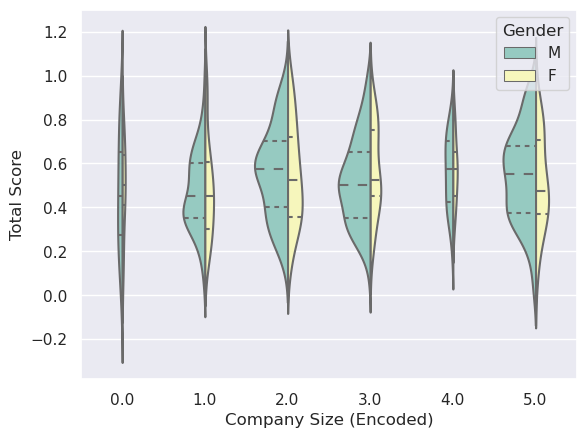

In [609]:
ax3 = sns.violinplot(x="Company Size (Encoded)", y="Total Score", hue="Gender",
                    data=df, palette="Set3", split=True,
                    scale="count", inner="quartile", scale_hue=False)

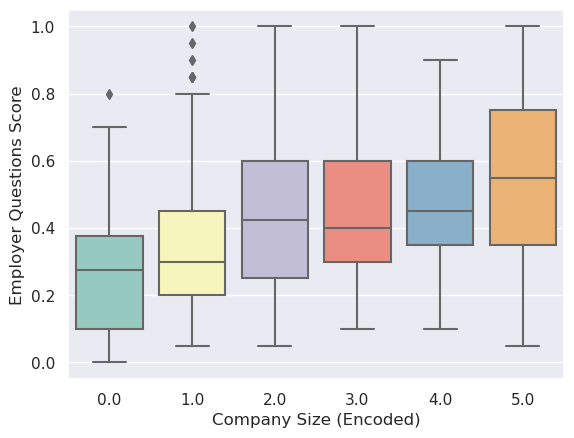

In [610]:
ax = sns.boxplot(x="Company Size (Encoded)", y="Employer Questions Score", data=df, palette="Set3")

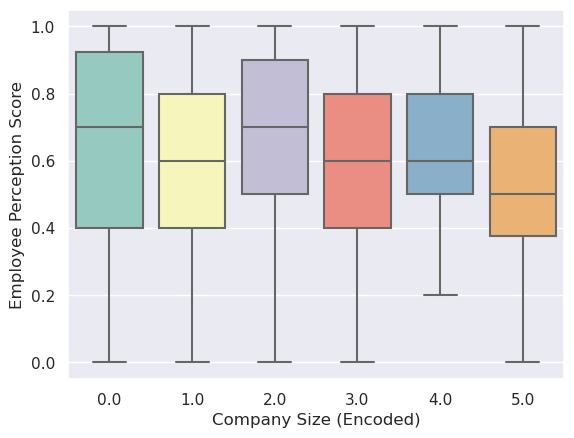

In [611]:
ax = sns.boxplot(x="Company Size (Encoded)", y="Employee Perception Score", data=df, palette="Set3")

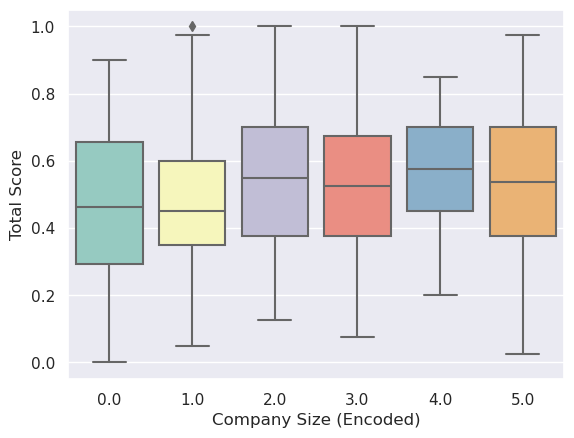

In [612]:
ax = sns.boxplot(x="Company Size (Encoded)", y="Total Score", data=df, palette="Set3")

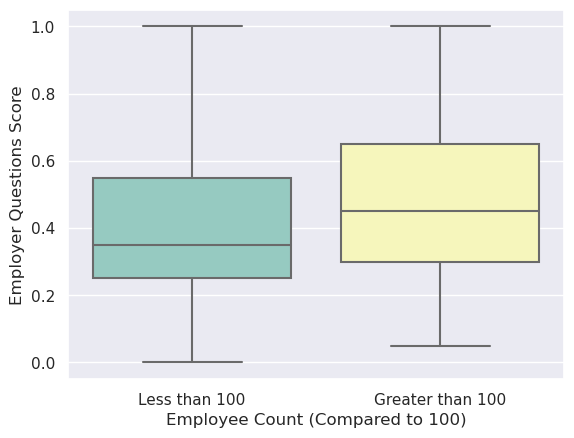

In [613]:
ax = sns.boxplot(x="Employee Count (Compared to 100)", y="Employer Questions Score", data=df, palette="Set3")

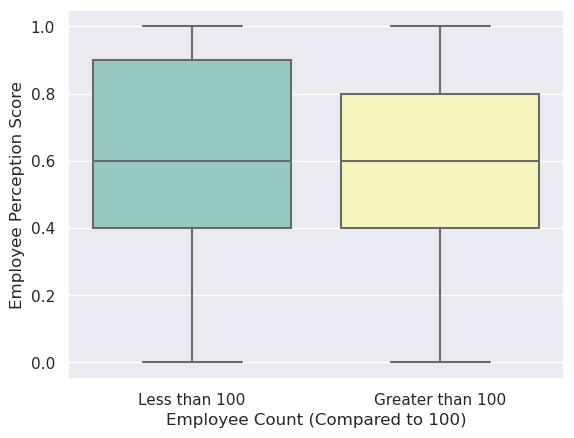

In [614]:
ax = sns.boxplot(x="Employee Count (Compared to 100)", y="Employee Perception Score", data=df, palette="Set3")

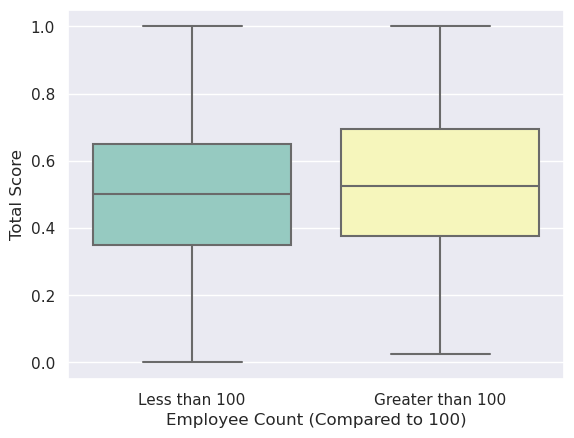

In [615]:
ax = sns.boxplot(x="Employee Count (Compared to 100)", y="Total Score", data=df, palette="Set3")

### Modeling:

In [616]:
inputs = ['Age','Company Size (Encoded)']
output =['Total Score']
# input__ = ['Employee Count (Compared to 100)']
outputs = ['Employer Questions Score', 'Employee Perception Score', 'Total Score']

from sklearn import preprocessing
from sklearn import utils
lab_enc = preprocessing.LabelEncoder()
for output in outputs:
    df.loc[:, [output]] = lab_enc.fit_transform(df[output])

df.loc[:, ['Employee Count (Compared to 100)']] = OrdinalEncoder().fit_transform(df[['Employee Count (Compared to 100)']])
df.loc[:, ['Gender']] = OrdinalEncoder().fit_transform(df[['Gender']])

In [617]:
# from sklearn.model_selection import train_test_split
# X = np.asarray(df[inputs])
# y = np.asarray(df[output])
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [618]:
from sklearn.model_selection import train_test_split
X = np.asarray(df[['Employee Perception Score', 'Employer Questions Score']])
#y = np.asarray(df['Company Size (Encoded)'])
y = np.asarray(df['Employee Count (Compared to 100)'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=22)
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data
pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.6666666666666666

In [619]:
from sklearn.tree import DecisionTreeClassifier
# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=232)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)


0.5942028985507246

In [620]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.6666666666666666

In [621]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.67


In [622]:
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
print('Accuracy of SVC classifier on test set: {:.2f}'.format(svc_clf.score(X_test, y_test)))

Accuracy of SVC classifier on test set: 0.68


In [623]:
from sklearn import model_selection
from numpy import array
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
cv = KFold(4, True, 1)
model = LogisticRegression()
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.603 (0.016)


/usr/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [624]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.6811594202898551

In [625]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=500)
sgd_clf.fit(X_train, y_train)
sgd_clf.score(X_test, y_test)

0.4782608695652174

In [626]:
from sklearn.neighbors import KNeighborsClassifier
kn_clf = KNeighborsClassifier(300)
kn_clf.fit(X_train, y_train)
kn_clf.score(X_test, y_test)

0.6811594202898551

In [0]:
def predict_company_size(inputs):
    inputs = lab_enc.fit_transform(inputs)
    print(inputs)
    return logreg.predict(inputs)